<a href="https://colab.research.google.com/github/hebaashraf21/KNN_K-means_PCA_CUDA_Implementation/blob/main/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Setup cuda environment
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-7y0yaj8_
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-7y0yaj8_
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 326b0a57a80c6d0b4bad25ca7adf8138419ef1cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-4l9fjsyf/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpstj_e3yu".


In [17]:
import time
import numpy as np
from numba import cuda


def knn_without_cuda(reference_points, query_points, k):
    results = []
    for query_point in query_points:
        distances = np.linalg.norm(reference_points - query_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        results.append(nearest_indices)
    return results



# Generate sample data
reference_points = np.random.rand(100000, 3)
query_points = np.random.rand(10000, 3)
k = 5

# Measure time for non-CUDA implementation
start_time = time.time()
knn_without_cuda(reference_points, query_points, k)
end_time = time.time()
print("Time taken without CUDA:", end_time - start_time, "seconds")



Time taken without CUDA: 121.95462989807129 seconds


In [37]:
%%writefile knn_comparison.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <assert.h>
#include <cuda_runtime.h>
#include <time.h>

#define MAX_ERR 1e-6

__global__ void knn_kernel(float *reference_points, float *query_points, int *results, int n, int m, int k, int dimensions) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < m) {
        float distances[1000];
        int indices[1000];

        for (int i = 0; i < n; ++i) {
            float distance = 0;
            for (int j = 0; j < dimensions; ++j) {
                float diff = reference_points[i * dimensions + j] - query_points[idx * dimensions + j];
                distance += diff * diff;
            }
            distances[i] = distance;
            indices[i] = i;
        }

        for (int i = 0; i < k; ++i) {
            for (int j = i + 1; j < n; ++j) {
                if (distances[i] > distances[j]) {
                    float temp_distance = distances[i];
                    distances[i] = distances[j];
                    distances[j] = temp_distance;
                    int temp_index = indices[i];
                    indices[i] = indices[j];
                    indices[j] = temp_index;
                }
            }
        }

        for (int i = 0; i < k; ++i) {
            results[idx * k + i] = indices[i];
        }
    }
}

void knn_with_cuda(float *reference_points, float *query_points, int *results, int n, int m, int k, int dimensions) {
    float *d_reference, *d_query;
    int *d_results;

    cudaMalloc((void **)&d_reference, sizeof(float) * dimensions * n);
    cudaMalloc((void **)&d_query, sizeof(float) * dimensions * m);
    cudaMalloc((void **)&d_results, sizeof(int) * m * k);

    cudaMemcpy(d_reference, reference_points, sizeof(float) * dimensions * n, cudaMemcpyHostToDevice);
    cudaMemcpy(d_query, query_points, sizeof(float) * dimensions * m, cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (m + blockSize - 1) / blockSize;

    knn_kernel<<<numBlocks, blockSize>>>(d_reference, d_query, d_results, n, m, k, dimensions);

    cudaMemcpy(results, d_results, sizeof(int) * m * k, cudaMemcpyDeviceToHost);

    cudaFree(d_reference);
    cudaFree(d_query);
    cudaFree(d_results);
}

void knn_without_cuda(float *reference_points, float *query_points, int *results, int n, int m, int k, int dimensions) {
    for (int idx = 0; idx < m; ++idx) {
        float *distances = (float *)malloc(n * sizeof(float));
        int *indices = (int *)malloc(n * sizeof(int));
        for (int i = 0; i < n; ++i) {
            float distance = 0;
            for (int j = 0; j < dimensions; ++j) {
                float diff = reference_points[i * dimensions + j] - query_points[idx * dimensions + j];
                distance += diff * diff;
            }
            distances[i] = distance;
            indices[i] = i;
        }
        // Sort the distances and find the k smallest
        for (int i = 0; i < n - 1; ++i) {
            for (int j = i + 1; j < n; ++j) {
                if (distances[i] > distances[j]) {
                    float temp_distance = distances[i];
                    distances[i] = distances[j];
                    distances[j] = temp_distance;
                    int temp_index = indices[i];
                    indices[i] = indices[j];
                    indices[j] = temp_index;
                }
            }
        }
        for (int i = 0; i < k; ++i) {
            results[idx * k + i] = indices[i];
        }
        free(distances);
        free(indices);
    }
}

int main() {
    int dimensions = 3; // Number of dimensions

    // Array of different sizes for testing
    int sizes[] = {100,1000};
    int num_sizes = sizeof(sizes) / sizeof(sizes[0]);

    float *reference_points;
    float *query_points;
    int *results;
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    printf("Size,Time with CUDA,Time without CUDA\n");
    for (int s = 0; s < num_sizes; ++s) {
        int n = sizes[s]; // Number of reference points
        int m = sizes[s] / 10; // Number of query points
        int k = 5; // Number of nearest neighbors

        reference_points = (float *)malloc(sizeof(float) * dimensions * n);
        query_points = (float *)malloc(sizeof(float) * dimensions * m);
        results = (int *)malloc(sizeof(int) * m * k);

        // Initialize reference_points and query_points with random values
        for (int i = 0; i < dimensions * n; ++i) {
            reference_points[i] = static_cast<float>(rand()) / RAND_MAX;
        }
        for (int i = 0; i < dimensions * m; ++i) {
            query_points[i] = static_cast<float>(rand()) / RAND_MAX;
        }

        // Measure time for CUDA implementation
        cudaEventRecord(start);
        knn_with_cuda(reference_points, query_points, results, n, m, k, dimensions);
        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float milliseconds_cuda = 0;
        cudaEventElapsedTime(&milliseconds_cuda, start, stop);

        // Measure time for non-CUDA implementation
        clock_t start_cpu = clock();
        knn_without_cuda(reference_points, query_points, results, n, m, k, dimensions);
        clock_t end_cpu = clock();
        float milliseconds_cpu = 1000.0 * (end_cpu - start_cpu) / CLOCKS_PER_SEC;

        printf("%d,%f,%f\n", n, milliseconds_cuda, milliseconds_cpu);


        free(reference_points);
        free(query_points);
        free(results);
    }

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}


Overwriting knn_comparison.cu


In [38]:
!nvcc knn_comparison.cu -o knn_comparison
!./knn_comparison > knn_times.csv


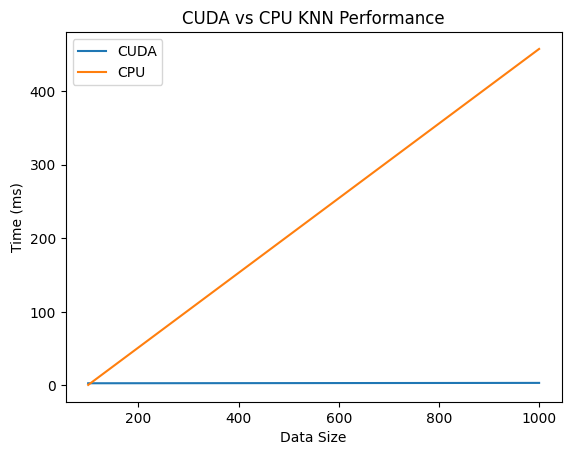

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the timing results
data = pd.read_csv('knn_times.csv')

# Plot the results
plt.plot(data['Size'], data['Time with CUDA'], label='CUDA')
plt.plot(data['Size'], data['Time without CUDA'], label='CPU')
plt.xlabel('Data Size')
plt.ylabel('Time (ms)')
plt.title('CUDA vs CPU KNN Performance')
plt.legend()
plt.show()
